In [1]:
import pickle
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from sklearn.cluster import KMeans
import re
from sklearn.decomposition import PCA
from collections import *
from scipy.signal import butter, filtfilt


file = open(r"C:\Users\Mahmo\Desktop\BCM_SIDS_ML_Summer_22\data\trials_breath.obj", "rb")
trials_breath = pickle.load(file)
file = open(r"C:\Users\Mahmo\Desktop\BCM_SIDS_ML_Summer_22\data\trials_ecg.obj", "rb")
trials_ecg = pickle.load(file)
file = open(r"C:\Users\Mahmo\Desktop\BCM_SIDS_ML_Summer_22\data\static_data.obj", "rb")
static_data = pickle.load(file)
file = open(r"C:\Users\Mahmo\Desktop\BCM_SIDS_ML_Summer_22\data\trials_raw.obj", "rb")
trials_raw = pickle.load(file)
metadata = pd.read_csv(r"C:\Users\Mahmo\Desktop\BCM_SIDS_ML_Summer_22\data\d2k project metadata.csv")

In [18]:
def butter_bandpass(lowcutoff, highcutoff, fs, order):
    """
    This function takes in the filter parameters and
    does the simple calculations needed to account for the
    Nyquist frequency and using the scipy butter function
    to produce the numerator and polynomials of the IIR filter \n
    Inputs: \n
    1) lowcutoff - lower frequecy cutoff of bandpass filter
    2) highcutoff - upper frequecy cutoff of bandpass filter
    3) fs - sampling frequency
    4) order - filter order \n
    Outputs: \n
    1) a - denominator polynomials of the IIR filter
    2) b - numerator polynomials of the IIR filter

    """
    nyq = 0.5 * fs  #nyquist frequency
    lowcutoff = lowcutoff / nyq        
    highcutoff = highcutoff / nyq
    a,b = butter(order, [lowcutoff, highcutoff], analog=False, btype='bandpass',output = 'ba')
    return a,b

def butter_bandpass_filter(data, lowcutoff, highcutoff, fs, order):
    """
    This function wraps the scipy functions needed to implement a 
    bandpass fillter and ultimately filters the signal \n
    Inputs: \n
    1) data - signal to be filtered
    2) lowcutoff - lower frequecy cutoff of bandpass filter
    3) highcutoff - upper frequecy cutoff of bandpass filter
    4) fs - sampling frequency
    5) order - filter order \n
    Outputs: \n
    1) filtered_signal

    """
    a,b = butter_bandpass(lowcutoff, highcutoff, fs, order=order)
    filtered_signal = filtfilt(a,b, data)
    return filtered_signal

def bandpass_filter(low, high, fs,order, signal, quiet = False):
    """
    This function bandpasses filters a given signal and has an option
    of plotting what the signal looks like before and after filtering \n
    Inputs: \n
    1) low - lower frequecy cutoff of bandpass filter
    2) high - upper frequecy cutoff of bandpass filter
    3) fs - sampling frequency
    4) order - filter order 
    5) signal - signal to be filtered
    6) quiet - (default: False) boolean indicating whether or not to display signal before and after filtering \n
    Outputs: \n
    1) filtered_data

    """
    filtered_data = butter_bandpass_filter(signal, low, high, fs, order)

    if quiet == False:    
        plt.figure(figsize = (8,8))
        plt.plot(signal, label='Raw signal')
        plt.title("Unfiltered signal", size = 10)
        plt.xlabel("Time (ms)", size = 10)
        plt.ylabel("Ventflow", size = 10)

        plt.figure(figsize = (8,8))
        plt.plot(filtered_data)
        plt.title("Bandpass Filtered Signal, Cutoff = {}-{} Hz" .format(low,high), size = 10)
        plt.xlabel("Time (ms)", size = 10)
        plt.ylabel("Ventflow", size = 10)

    return filtered_data

def compute_timestamps(metadata, mouse_id, all = False, breath_only = False, phase = None, phase2 = None, phase3 = None, phase4 = None):
    """
    Given the required phase(s) and metadata, this function returns all the timestamps in which
    the given phase occurs in seconds as a list \n  

    Inputs:
    1) metadata
    2) mouse_id
    3) all - (default: False) boolean indicating whether all timestamps in experiments are requested as opposed to a select few
    4) breath_only - (default: False) Only if all == True. Excludes all HR Recovery timestamps when set to true
    5) phase, phase2, ... - all phases requested. At least 1 and at most 5 phases.

    if all == True, all timestamps in the experiment is returned \n
    Output formatted as follows: \n
        timestamps_in_s["trial"] = []
        timestamps_in_s["other"]["timestamp"] = [all timestamps for non-trial onset]
        timestamps_in_s["other"]["comment"] = [names of all timestamps for not-trial onset]  \n
    if all == false, only specified timestamps are returned \n
    Output is just a list of timestamps
    """
        
    if not all:
        #retreiving all relevant timestamps
        timestamps_in_hms = list(metadata[((metadata["Comment"] == phase) | (metadata["Comment"] == phase2) | (metadata["Comment"] == phase3) | (metadata["Comment"] == phase4)) & (metadata["source file"] == mouse_id)]["Time"])
        timestamps_in_s = []
        
        #converting timstamps from h:m:s to seconds
        for timestamp in timestamps_in_hms:
            processed_timestamp = re.split(':', timestamp)
            timestamp = [float(i) for i in processed_timestamp]   
            if len(timestamp) == 1:
                timestamps_in_s.append(timestamp[0])
            elif len(timestamp) == 2:
                timestamps_in_s.append(60*timestamp[0]+timestamp[1])
            elif len(timestamp) == 3:
                timestamps_in_s.append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])

        return timestamps_in_s

    else: #retreive all timestamps in experiment
        comments = list(metadata[metadata["source file"] == mouse_id]["Comment"]) 
        timestamps_in_hms = list(metadata[metadata["source file"] == mouse_id]["Time"]) 
        timestamps_in_s = defaultdict(lambda: defaultdict(str))

        if breath_only:  #exclude HR recovery timestamps
            other_comments = []
            other_timestamps = []
            for timestamp in range(0,len(comments)):
                if comments[timestamp] not in ["HR recovery","Hr recovery","HR recovery - No signal", "hr recovery"]:
                    other_comments.append(comments[timestamp])
                    other_timestamps.append(timestamps_in_hms[timestamp])
            timestamps_in_hms = other_timestamps
            comments = other_comments

        timestamps_in_s["trial"] = []
        timestamps_in_s["other"]["timestamp"] = []
        timestamps_in_s["other"]["comment"] = []

        #converting all hms timestamps 
        for stage in range(0,len(comments)):
            if comments[stage].isdecimal(): #if timestamps is trial onset, it is assigned elsewehere
                processed_timestamp = re.split(':', timestamps_in_hms[stage])
                timestamp = [float(i) for i in processed_timestamp]   
                if len(timestamp) == 1:
                    timestamps_in_s["trial"].append(timestamp[0])
                    timestamps_in_s["other"]["timestamp"].append((timestamp[0]))
                elif len(timestamp) == 2:
                    timestamps_in_s["trial"].append(60*timestamp[0]+timestamp[1])
                    timestamps_in_s["other"]["timestamp"].append((60*timestamp[0]+timestamp[1]))
                elif len(timestamp) == 3:
                    timestamps_in_s["trial"].append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])
                    timestamps_in_s["other"]["timestamp"].append((3600*timestamp[0]+60*timestamp[1]+timestamp[2]))
                timestamps_in_s["other"]["comment"].append(comments[stage])
            else:
                if not comments[stage][1:].isdecimal():
                    processed_timestamp = re.split(':', timestamps_in_hms[stage])
                    timestamp = [float(i) for i in processed_timestamp]   
                    if len(timestamp) == 1:
                        timestamps_in_s["other"]["timestamp"].append((timestamp[0]))
                    elif len(timestamp) == 2:
                        timestamps_in_s["other"]["timestamp"].append((60*timestamp[0]+timestamp[1]))
                    elif len(timestamp) == 3:
                        timestamps_in_s["other"]["timestamp"].append((3600*timestamp[0]+60*timestamp[1]+timestamp[2]))
                    timestamps_in_s["other"]["comment"].append(comments[stage])

        return timestamps_in_s

def retrieve_phase(meta_data, raw_data, static_data, trial_data,data_type,label1, label2 = None, label3 = None, label4 = None, trial_onset_first = bool, otherlabel = None, otherlabel2 = None):
    """
    Inputs: \n
    1) meta_data (required): metadata \n
    2) raw_data (required):  raw_data \n
    3) static_data (required) \n
    4) trial_data (required): either trials_ecg, trials_breath \n
    5) data_type (required): either "ECG" or "Breathing_flow_signal" \n
    6) trial_onset_first (required): specify whether the desired phase starts or ends with trial onset or not. Set to False if other_label is phase onset \n
    7) label1, label2,.. label4 (optional) (default=None): string representing desired phase timestamp, has multiple options in case the same phase was referenced in different ways in the metadata \n
    8) other_label (optional) (default=None): specify other end of phase if it's not a trial onset (e.g. looking for interval from apnea start to recovery
                 as opposed to looking for phase HR to next trial onset or looking for phase trial onset to apnea start) \n
    
    Outputs: \n
    1) interval_information_df - dataframe on mouse ID and experimental type information encoded as natural numbers for plotting purposes \n
    2) min_interval_length - minimum length of all the phases extracted in this function \n
    3) phase_interval_per_mouse - function mapping each mouse to a mapping from a number to its corresponding phase
                               (i.e 3 phase means 1:phase1, 2:phase2,3:phase3) where each
                                phase is a dataframe \n
    Method: \n
    Upon specificying the desired phase boundaries (HR recovery to trial onset/ trial onset to apnea/ eupnea recovery to trial onset ..etc) \n
    this function returns the desired phases as a dataframe in the format specified above. This function defaults to finding the phases that either \n
    start or ends with trial onset unless other_label is specified in which case other_label offsets that defualt setting in case a start/end \n
    different from trial onset is desired.
    """
    
    mice = list(trial_data.keys())
    phase_interval_per_mouse = defaultdict(lambda : defaultdict(int))
    min_interval_length = float("inf")

    phase_interval_number = []
    mouse_IDs = []
    mouse_ID_no = []
    mouse_type = []
    mouse_type_no = []
    mouse_genotypes = {}
    
    #
    i = 0
    for mouse_line in static_data["Line"].unique():
        for exp_type in static_data["Genotype"].unique():
            i += 1
            mouse_genotypes[mouse_line + " " + exp_type] = i
    j = 0
    #going through all the mice to extract the desired phases from each of their experiments
    for mouse in mice:
        j += 1
        print("Currently retrieving interval information for mouse {0}. Progress: {1}%" .format(mouse,100*((mice.index(mouse) + 1)/len(mice))))

        #different method for extracting the desired phase start/end timstamps depending on whether phase starts/ends with a trial onset
        if otherlabel:
            other_phase_timestamps = []
            other_phase_timestamps = compute_timestamps(meta_data,str(mouse), all=False, phase=otherlabel, phase2=otherlabel2)
        else:
            trials_survived = int(raw_data[str(mouse)]["raw"]["trial_no"].unique()[-1])
            other_phase_timestamps = []
            if trial_onset_first:
                for trial in range(1,trials_survived+1):
                    timestamp_now = int(compute_timestamps(meta_data,str(mouse),all=False,phase=str(trial))[0])
                    if timestamp_now < len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                        other_phase_timestamps.append(timestamp_now)
            else:
                for trial in range(2,trials_survived+1):
                    timestamp_now = int(compute_timestamps(meta_data,str(mouse),all=False,phase=str(trial))[0])
                    if timestamp_now < len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                        other_phase_timestamps.append(timestamp_now)

        #compute timestamps for other end of inteval
        phase_onset_timestamps = compute_timestamps(meta_data,str(mouse), phase=label1, phase2 = label2, phase3= label3, phase4= label4)
        
        #even out timestamps list in case this mouse has not completed a full iteration of desired phase
        if len(phase_onset_timestamps) > len(other_phase_timestamps):
            del(phase_onset_timestamps[-1])
        elif len(phase_onset_timestamps) < len(other_phase_timestamps):
            del(other_phase_timestamps[-1])

        #removing timestamp if it's out of range of the data we're given. This is due to error in metadata/data provided
        for timestamp in phase_onset_timestamps:
            if int(timestamp) > len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                phase_onset_timestamps.remove(timestamp)       
        if otherlabel:
            for timestamp in other_phase_timestamps:
                if int(timestamp) > len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                    other_phase_timestamps.remove(timestamp)

        #extracting each phase one at a time
        for phase_interval in range(0,len(phase_onset_timestamps)):          
            #we determine how to set our interval starting and ending indices based on whether the desired phase starts or ends with trial onset
            if not trial_onset_first:
                current_interval_start = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.ceil(phase_onset_timestamps[phase_interval]) > 0]
                current_interval_end = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.floor(other_phase_timestamps[phase_interval]) > 0]
            else:
                current_interval_start = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.ceil(other_phase_timestamps[phase_interval]) > 0]
                current_interval_end = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.floor(phase_onset_timestamps[phase_interval]) > 0]
            
            #retrieving our desired phase start and ending index
            current_interval_start_timestamp = current_interval_start["Timestamp"].iloc[0]
            current_interval_end_timestamp = current_interval_end["Timestamp"].iloc[0]

            start_index = raw_data[str(mouse)]["raw"].index[raw_data[str(mouse)]["raw"]["Timestamp"] > current_interval_start_timestamp][0]
            end_index = raw_data[str(mouse)]["raw"].index[raw_data[str(mouse)]["raw"]["Timestamp"] > current_interval_end_timestamp][0]
        
            #find current interval and include it in phase_interval_per_mouse
            if (start_index < len(raw_data[str(mouse)]["raw"][str(data_type)])) & (end_index < len(raw_data[str(mouse)]["raw"][str(data_type)])):
                current_interval = raw_data[str(mouse)]["raw"][str(data_type)][start_index:end_index].reset_index()
                phase_interval_per_mouse[mouse][phase_interval] = current_interval
            
            #finding minium_interval_length
            if len(current_interval) < min_interval_length:
                min_interval_length = len(current_interval)

            if min_interval_length == 0:
                raise ValueError("{}, {}, mouse:{}, start: {}, end: {}, total length: {}" .format(other_phase_timestamps, phase_onset_timestamps, mouse, start_index, end_index, 
                                                                                            len(raw_data[str(mouse)]["raw"][str(data_type)])))

            #collect information to create interval_information_df
            mouse_ID_no.append(j)
            mouse_IDs.append(mouse)
            phase_interval_number.append(phase_interval + 1)
            genotype = static_data[static_data["MUID"] == str(mouse)]["Line"].item() + " " + static_data[static_data["MUID"] == str(mouse)]["Genotype"].item()
            mouse_type.append(genotype)
            mouse_type_no.append(mouse_genotypes[genotype])

    #creating inverval_information_df 
    interval_information_df = pd.DataFrame(list(zip(mouse_ID_no,mouse_IDs, phase_interval_number, mouse_type, mouse_type_no)), columns = ["Mouse ID #","Mouse ID", "Recovery interval #", "Mouse Type", "Mouse Type #"])

    return interval_information_df, min_interval_length, phase_interval_per_mouse


In [19]:
info_df, min_length, phase_data_df = retrieve_phase(metadata, trials_raw, static_data, trials_ecg, "ECG", label1= "HR recovery", label2="Hr recovery", label3="HR recovery - No signal", label4 = "hr recovery", trial_onset_first=False)

Currently retrieving interval information for mouse M20864. Progress: 5.0%
Currently retrieving interval information for mouse M20865. Progress: 10.0%
Currently retrieving interval information for mouse M20867. Progress: 15.0%
Currently retrieving interval information for mouse M20868. Progress: 20.0%
Currently retrieving interval information for mouse M20869. Progress: 25.0%
Currently retrieving interval information for mouse M20870. Progress: 30.0%
Currently retrieving interval information for mouse M20874. Progress: 35.0%
Currently retrieving interval information for mouse M21480. Progress: 40.0%
Currently retrieving interval information for mouse M21481. Progress: 45.0%
Currently retrieving interval information for mouse M21483. Progress: 50.0%
Currently retrieving interval information for mouse M21484. Progress: 55.00000000000001%
Currently retrieving interval information for mouse M21486. Progress: 60.0%
Currently retrieving interval information for mouse M21487. Progress: 65.0%


In [17]:
trials_raw["M20864"]["raw"]

,Timestamp,Breathing_flow_signal,O2_sensor_data,CO2_sensor_data,Chamber_temperature,ECG,Heart_Rate,Integrated_Flow,Breathing,trial_no
101599,101.599998,-0.152187,2.090313,0.005937,34.6875,0.000140,NaN,-15.732080,-0.000074,-1.0
101600,101.600998,-0.152500,2.089375,0.006250,35.3125,-0.000180,NaN,-15.732220,-0.000074,-1.0
101601,101.601997,-0.152187,2.089688,0.005937,34.6875,0.000753,NaN,-15.732400,-0.000099,-1.0
101602,101.602997,-0.151875,2.089688,0.006562,35.0000,-0.000185,NaN,-15.732550,-0.000099,-1.0
101603,101.603996,-0.152812,2.089688,0.007188,34.6875,-0.000495,NaN,-15.732700,-0.000124,-1.0
...,...,...,...,...,...,...,...,...,...,...
4144769,4144.794922,-0.159688,2.075625,0.022500,34.6875,0.001533,NaN,-648.489807,-0.149673,3.0
4144770,4144.795898,-0.160313,2.074688,0.021875,35.0000,0.004346,NaN,-648.489990,-0.149847,3.0
4144771,4144.796875,-0.161250,2.075625,0.022187,35.0000,0.006533,NaN,-648.490112,-0.149971,3.0
4144772,4144.797852,-0.163125,2.075625,0.021875,35.3125,0.009658,NaN,-648.490295,-0.150169,3.0


In [ ]:
breath_info_df, breath_min_length, breath_phase_data_df = retrieve_phase(metadata, trials_raw, static_data, trials_ecg, "Breathing_flow_signal", label1= "eupnea recovery", label2="eupnea starts", trial_onset_first=False)

In [ ]:
apnea_info_df, apnea_min_length, apnea_phase_data_df = retrieve_phase(metadata, trials_raw, static_data, trials_ecg, "Breathing_flow_signal", label1= "apnea starts", label2="apea starts", trial_onset_first=True)

In [ ]:
gasp_info_df, gasp_min_length, gasp_phase_data_df = retrieve_phase(metadata, trials_raw, static_data, trials_ecg, "Breathing_flow_signal", label1= "apnea starts", label2="apea starts", otherlabel= "first gasp", trial_onset_first=False)

In [ ]:
gasp2rec_info_df, gasp2rec_min_length, gasp2rec_phase_data_df = retrieve_phase(metadata, trials_raw, static_data, trials_ecg, "Breathing_flow_signal", label1= "first gasp", otherlabel= "eupnea starts", otherlabel2= "eupnea recovery", trial_onset_first=False)

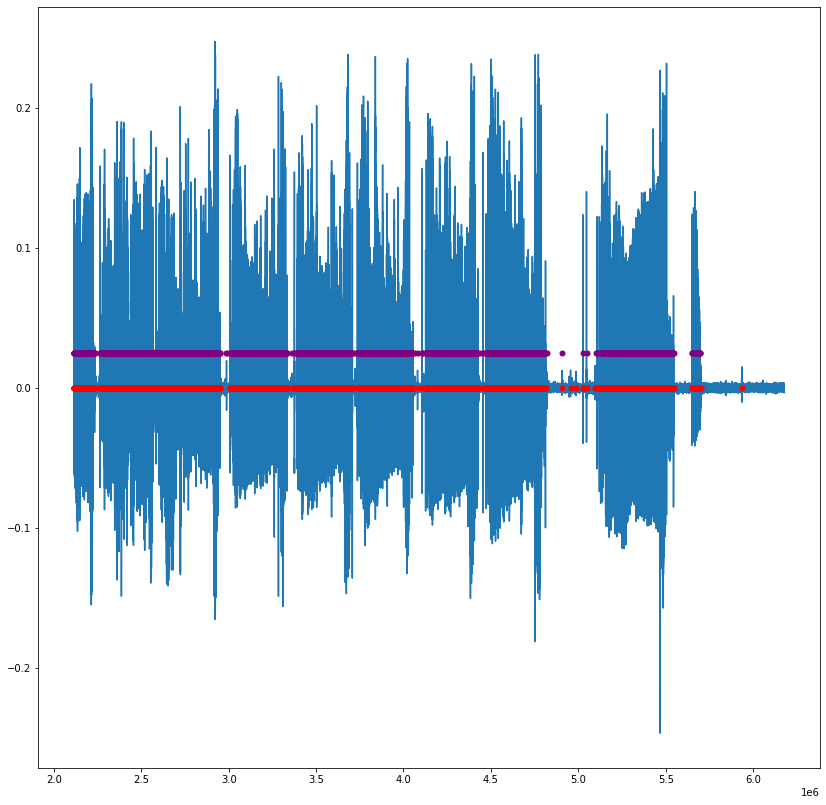

In [8]:
from scipy.signal import find_peaks
from scipy.integrate import cumtrapz

mouse = "M20868"
start = 4250000
end = start + 1000000

data = trials_raw[mouse]["raw"][trials_raw[mouse]["raw"]["trial_no"] >= 0]

if "index" in data.columns:
    time = np.array(data["index"])
else:  
    time = data.index

breathlists = trials_breath[mouse]["breath"][(trials_breath[mouse]["breath"]["Breath Number"] > time[0]) & (trials_breath[mouse]["breath"]["Breath Number"] < time[-1])]

y = bandpass_filter(1,15,1000,2,data["Breathing_flow_signal"], quiet = True)

plt.figure(figsize=(14,14))
plt.plot(time,y)

y = cumtrapz(y, x=time)

peaks1, _ = find_peaks(-y, distance = 200, prominence = 1.05)

x = np.arange(0,np.shape(y)[0])
sortId = np.argsort(x)
x = x[sortId]
y = y[sortId]

plt.plot(peaks1+time[0], np.zeros(len(peaks1)), ".", c = "red", markersize=10)
plt.plot(breathlists["Timestamp_Inspiration"]*1000,np.zeros(len(breathlists["Timestamp_Inspiration"])) + 0.025, ".", c = "purple", markersize=10)
plt.show()

In [ ]:
#calibration

for mouse in trials_raw.keys():
    calibr = compute_timestamps(metadata, mouse, phase = "Cal 20 Room Air")
    start = calibr[-1] * 1e3
    end = start + 4e4
    calibration_volume = 20
    trials_breath[mouse]["breath"]["bpm"] = 60 / trials_breath[mouse]["breath"]["Inspiratory_Duration"]
    data_subset = trials_breath[mouse]["breath"][(trials_breath[mouse]["breath"]["Breath Number"] > start) & (trials_breath[mouse]["breath"]["Breath Number"] < end) & ((trials_breath[mouse]["breath"]["bpm"] > 60))]
    number_breath = len(data_subset)
    avg_tidal = np.mean(data_subset["Tidal_Volume_uncorrected"])
    if mouse in ["M21267","M21269","M20868"]:
        print("Mouse {} avg_tide value: {} Number of breaths: {} ***" .format(mouse,avg_tidal, number_breath))
    else:
        print("Mouse {} avg_tide value: {} Number of breaths: {}" .format(mouse,avg_tidal, number_breath))



(1367458.0, 1369458.0)

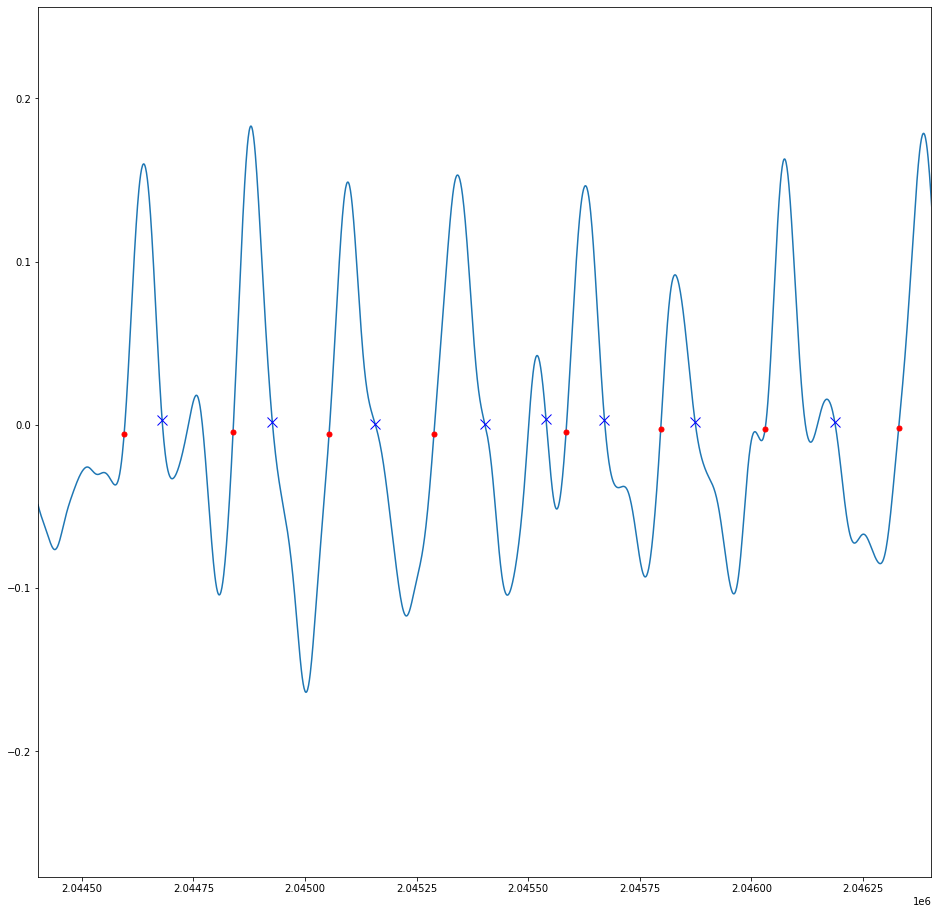

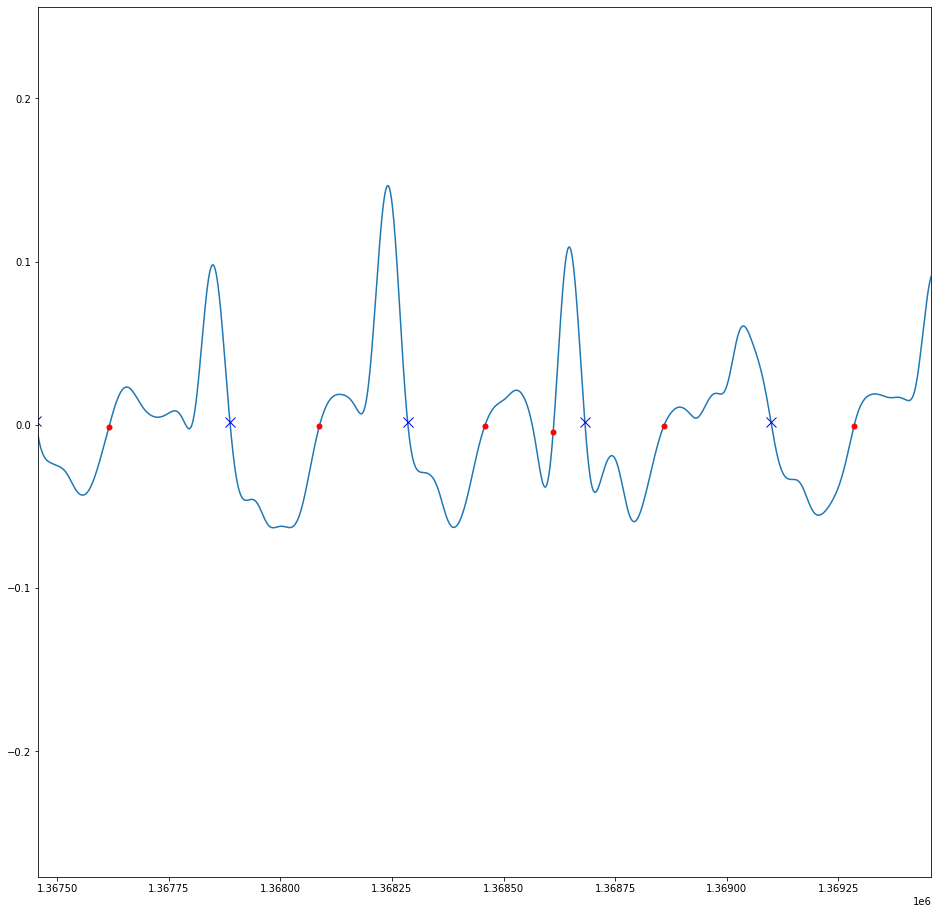

In [191]:
from scipy.integrate import cumtrapz
from scipy.signal import find_peaks

mouse = "M20864"

data = trials_raw[mouse]["raw"]

time = data.index
breathlists = trials_breath[mouse]["breath"][(trials_breath[mouse]["breath"]["Breath Number"] > time[0]) & (trials_breath[mouse]["breath"]["Breath Number"] < time[-1])]
y = bandpass_filter(1,15,1000,2,data["Breathing_flow_signal"], quiet = True)

y_volume = cumtrapz(y, x=time)

peaks0, _ = find_peaks(y_volume, distance = 130, prominence = 0.8)
peaks1, _ = find_peaks(-y_volume, distance = 130, prominence = 0.8)

expiration =  [1] * len(peaks0)
inspiration =  [-1] * len(peaks1)

breath_out = list(zip(list(peaks0), expiration))
breath_in = list(zip(list(peaks1), inspiration))

all_breaths = breath_out + breath_in

all_breaths.sort(key=operator.itemgetter(0))

woow = list(zip(*all_breaths))
test = np.array(woow[1][:-1]) + np.array(woow[1][1:])

consecutives = np.where(test != 0)

for index in (consecutives+1):
    del all_breaths[index]
    consecutives -= 1

all_breaths.sort(key=operator.itemgetter(0))

woow = list(zip(*all_breaths))
test = np.array(woow[1][:-1]) + np.array(woow[1][1:])

consecutives = np.where(test != 0)

x = np.arange(0,np.shape(y_volume)[0])
sortId = np.argsort(x)
x = x[sortId]
y_volume = y_volume[sortId]

"""plt.figure(figsize=(12,12))
plt.plot(y_volume)
plt.plot(peaks0, y_volume[peaks0], "x", c = "red", markersize = 15)
plt.plot(peaks1, y_volume[peaks1], "x", c = "blue", markersize = 15)
plt.xlim(1.5e6,1.5e6+2000)
"""

x = np.arange(0,np.shape(y)[0])
sortId = np.argsort(x)
x = x[sortId]
y = y[sortId]

plt.figure(figsize=(16,16))
plt.plot(y)

plt.plot(peaks1, y[peaks1], ".", c = "red", markersize=10)
plt.plot(peaks0, y[peaks0], "x", c = "blue", markersize=10)
plt.xlim(2044403,2046403)


plt.figure(figsize=(16,16))
plt.plot(y)

plt.plot(peaks1, y[peaks1], ".", c = "red", markersize=10)
plt.plot(peaks0, y[peaks0], "x", c = "blue", markersize=10)
plt.xlim(1367458,1369458)

In [ ]:
import operator

for mouse in trials_raw.keys():
    data = trials_raw[mouse]["raw"]

    time = data.index
    breathlists = trials_breath[mouse]["breath"][(trials_breath[mouse]["breath"]["Breath Number"] > time[0]) & (trials_breath[mouse]["breath"]["Breath Number"] < time[-1])]
    y = bandpass_filter(1,15,1000,2,data["Breathing_flow_signal"], quiet = True)

    y_volume = cumtrapz(y, x=time)

    peaks0, _ = find_peaks(y_volume, distance = 130, prominence = 0.8)
    peaks1, _ = find_peaks(-y_volume, distance = 130, prominence = 0.8)

    expiration =  [1] * len(peaks0)
    inspiration =  [-1] * len(peaks1)

    breath_out = list(zip(list(peaks0), expiration))
    breath_in = list(zip(list(peaks1), inspiration))

    all_breaths = breath_out + breath_in

    all_breaths.sort(key=operator.itemgetter(0))

    woow = list(zip(*all_breaths))
    test = np.array(woow[1][:-1]) + np.array(woow[1][1:])

    consecutives = np.where(test != 0)[0]

    for index in consecutives:
        del all_breaths[index+1]
        consecutives -= 1


    all_breaths.sort(key=operator.itemgetter(0))

    woow = list(zip(*all_breaths))
    test = np.array(woow[1][:-1]) + np.array(woow[1][1:])

    consecutives = np.where(test != 0)
    print(len(all_breaths))


In [20]:
def trial_number(metadata, custom_breathlists, breath_start, mouse):
    """
    Given the custom breathlists dictionary mapping mouse IDs to their 
    corresponding custom breathlists, this function adds a column to that dataframe
    indicating the trial number in which each breath took place \n

    Inputs: \n
    1) metadata
    2) custom_breathlists - dictionary mapping each mouse ID to its corresponding custom breathlists
    3) breath_start - dataframe column indicating timestamps of inspiration
    4) mouse - mouse ID
    """

    #retreiving timestamps of each trials
    all_timestamps = compute_timestamps(metadata, mouse, all=True)

    #assigning trial number 0 to all breaths before onset of trial 1
    custom_breathlists[mouse].loc[breath_start < all_timestamps["trial"][0]*1000, "Trial Number"] = 0

    #assigning the last trial number to the breaths that happened in the last breath
    custom_breathlists[mouse].loc[breath_start > all_timestamps["trial"][-1]*1000, "Trial Number"] = len(all_timestamps["trial"])

    #assigning the rest of the trial numbers
    for timestamp in range(1,len(all_timestamps["trial"])):
        custom_breathlists[mouse].loc[(breath_start < all_timestamps["trial"][timestamp]*1000) & (breath_start > all_timestamps["trial"][timestamp-1]*1000), "Trial Number"] = timestamp-1

phase2number = {"Cal 20 Room Air": 0,
                "Pre-CNO Room Air": 1,
                "Pre-CNo Room Air": 1,
                "Post-CNO Room Air": 2,
                "Post-CNo Room Air": 2,
                "trial onset" : 3,
                "apea starts" : 4,
                "apnea starts" : 4,
                "first gasp" : 5,
                "eupnea starts" :6,
                "eupnea recovery" : 6,
                "Cal 5 Room Air": 7
                }

number2phase = {0 : "Cal 20 Room Air",
                1 : "Pre-CNO Room Air",
                2 : "Post-CNO Room Air",
                3 : "Trial Onset",
                4 : "Apnea Starts",
                5 : "First Gasp",
                6 : "Eupnea Recovery",
                7 : "Cal 5 Room Air"
                }

def phase_type(metadata, custom_breathlists, breath_start, mouse, phase2number, number2phase):
    """
    Given the custom breathlists dictionary mapping mouse IDs to their 
    corresponding custom breathlists, this function adds a column to that dataframe
    indicating the phase in which each breath took place and another column indicating an
    arbitraty code number corresponding to that phase \n

    Inputs: \n
    1) metadata
    2) custom_breathlists - dictionary mapping each mouse ID to its corresponding custom breathlists
    3) breath_start - dataframe column indicating timestamps of inspiration
    4) mouse - mouse ID
    5) phase2number - arbitrary mapping of phase name to an arbitrarily chosen integer
    6) number2phase - inverese of phase2number
    """

    #retrieving all timestamps in the experiment
    all_timestamps = compute_timestamps(metadata, mouse, all=True, breath_only = True)

    custom_breathlists[mouse].loc[breath_start < all_timestamps["other"]["timestamp"][0]*1000, "Phase Number"] = phase2number[all_timestamps["other"]["comment"][0]]
    custom_breathlists[mouse].loc[breath_start < all_timestamps["other"]["timestamp"][0]*1000, "Phase Type"] = number2phase[phase2number[all_timestamps["other"]["comment"][0]]]
    custom_breathlists[mouse].loc[breath_start > all_timestamps["other"]["timestamp"][-1]*1000, "Phase Number"] = phase2number[all_timestamps["other"]["comment"][-1]]
    custom_breathlists[mouse].loc[breath_start > all_timestamps["other"]["timestamp"][-1]*1000, "Phase Type"] = number2phase[phase2number[all_timestamps["other"]["comment"][-1]]]
    
    for timestamp in range(1,len(all_timestamps["other"]["timestamp"])):
        
        if all_timestamps["other"]["comment"][timestamp-1].isdecimal():
            custom_breathlists[mouse].loc[(breath_start < all_timestamps["other"]["timestamp"][timestamp]*1000) & (breath_start > all_timestamps["other"]["timestamp"][timestamp-1]*1000), "Phase Number"] = phase2number["trial onset"]
            custom_breathlists[mouse].loc[(breath_start < all_timestamps["other"]["timestamp"][timestamp]*1000) & (breath_start > all_timestamps["other"]["timestamp"][timestamp-1]*1000), "Phase Type"] = "Trial Onset"
        else:
            custom_breathlists[mouse].loc[(breath_start < all_timestamps["other"]["timestamp"][timestamp]*1000) & (breath_start > all_timestamps["other"]["timestamp"][timestamp-1]*1000), "Phase Number"] = phase2number[all_timestamps["other"]["comment"][timestamp-1]]
            custom_breathlists[mouse].loc[(breath_start < all_timestamps["other"]["timestamp"][timestamp]*1000) & (breath_start > all_timestamps["other"]["timestamp"][timestamp-1]*1000), "Phase Type"] = number2phase[phase2number[all_timestamps["other"]["comment"][timestamp-1]]]

def label_breaths(metadata, custom_breathlists, mouse, breath_start, phase2number, number2phase):
    """
    This function adds 3 columns to the custom breathlists dataframe: \n
    1) column with trial number in which each breath took place
    2) column with phase type in which each breath took place
    3) column with number corresponding to a phase type in which each breath took place based on the arbitrary phase2number assignments
    """
    trial_number(metadata, custom_breathlists, breath_start,mouse)

    phase_type(metadata,custom_breathlists, breath_start, mouse, phase2number, number2phase)

def extract_breath(data,start,end):
    """
    Given start and end timestamp of a given breath, this function
    extracts and returns the data corresponding to the breath as a
    normalized array
    """
    return np.array(data[start:end]) - np.mean(np.array(data[start:end]))


In [220]:
from scipy.integrate import cumtrapz
from scipy.signal import find_peaks
import operator

def clean_breath_data(raw_data, mouse, freqlow, freqhigh, filter_order, sampling_freq):
    """
    This function filters the raw breathing data and fixes an issue present in 3 of the mice \n

    Inputs: \n
    1) raw_data - 2D dictionary mapping each mouse ID to dataframe corresponding to its raw data
    2) mouse - mouse ID
    3) freqlow - lower bound for bandpass filter
    4) freqhigh - upper bound for bandpass filter
    5) filter_order - filter order
    6) sampling_freq - sampling frequency \n

    Outputs: \n
    1) data - raw_data dataframe corresponding to "mouse" but refined for use later
    2) filtered_data - array corresponding to breathing data from raw_data after filtering
    """
    
    #remove section of missing data from the only 3 mice with that problem
    timestamps = np.array(raw_data[mouse]["raw"]["Timestamp"])

    #time between each inspiration timestamps
    lengths = timestamps[1:] - timestamps[:-1]

    #excluding parts of breathing data missing readings for longer than a seconds
    if mouse in ["M20868", "M21267", "M21269"]:
        data = raw_data[mouse]["raw"][np.where(lengths>1)[0][0]+1:]
    else:
        data = raw_data[mouse]["raw"]

    #resetting index for consistency of the data with peak indices
    data.reset_index(drop = True, inplace= True)

    #filtering data
    filtered_data = bandpass_filter(freqlow,freqhigh,sampling_freq,filter_order,data["Breathing_flow_signal"], quiet = True)
    
    return data, filtered_data
    
def find_breath_timestamps(raw_data: dict, mouse: str, filtered_data, peak_prominence : float, p2p_min: float):
    """
    Tthis function returns the index of the first breath indicating when the mouse was first mounted on the rig.
    This function also returns the inspiration timestamps of all the breaths \n

    Inputs: \n
    1) raw_data - 2D dictionary mapping each mouse ID to dataframe corresponding to its raw data
    2) mouse - mouse ID
    3) filtered_data - array corresponding to breathing data from raw_data after filtering
    4) peak_prominence - value indicating how much higher the peaks we're looking for need to be than data around it
    5) p2p_min - minimum distance between two peaks 

    Outputs: \n
    1) mouse_online - timestamp during which mouse was mounted onto rig
    2) breath_timestamps - all inspiration timestamps 
    3) expiration_timestamps - all expiration timestamps
    """

    time = raw_data.index

    #finding all the timestamps of onset of inspiration and expiration
    y_volume = cumtrapz(filtered_data, x=time)
    peaks, _ = find_peaks(-y_volume, distance = p2p_min, prominence = peak_prominence)
    peaks = peaks + time[0]
    exp_peaks, _ = find_peaks(y_volume, distance = p2p_min, prominence = peak_prominence)
    exp_peaks = exp_peaks + time[0]

    #taking care of inconsistencies in a couple of the data files
    calibr = compute_timestamps(metadata, mouse, phase = "Cal 20 Room Air")
    if mouse not in ["M20868", "M21267", "M21269"]:
        narrowed_peaks = peaks[peaks > (calibr[-1]*1000 + 5e4)]
    else:
        narrowed_peaks = peaks

    #identifying where exactly in
    #the data the mouse is actually mounted onto the machine
    for peak in range(0,len(peaks)):
        distance = narrowed_peaks[peak+40] - narrowed_peaks[peak]
        if distance < 40e3:
            starter_peak = peak
            break
    
    #timestamp where the mouse was mounted on the rig
    mouse_online = raw_data["Timestamp"].iloc[narrowed_peaks[starter_peak]]

    #finding all the breaths detected after mouse mounted on rig
    breath_timestamps = narrowed_peaks[starter_peak:]
    expiration_timestamps = exp_peaks[exp_peaks > breath_timestamps[0]]
    
    peaks1=breath_timestamps
    peaks0=expiration_timestamps

    #accounting for all instances in which consective expirations were detected with
    #no insipirations inbetween and vice versa
    expiration =  [1] * len(peaks0)
    inspiration =  [-1] * len(peaks1)

    breath_out = list(zip(list(peaks0), expiration))
    breath_in = list(zip(list(peaks1), inspiration))

    all_breaths = breath_out + breath_in
    all_breaths.sort(key=operator.itemgetter(0))

    timestamp_type = list(zip(*all_breaths))
    test = np.array(timestamp_type[1][:-1]) + np.array(timestamp_type[1][1:])

    consecutives = np.where(test != 0)[0]

    for index in consecutives:
        del all_breaths[index+1]
        consecutives -= 1

    all_timestamps = np.array(list(zip(*all_breaths))[0])
    breath_timestamps = all_timestamps[0::2]
    expiration_timestamps = all_timestamps[1::2]

    #if last peak deteced was an inspiration, remove it. Making sure last peak detected was expiration
    if len(breath_timestamps) > len(expiration_timestamps):
        breath_timestamps = breath_timestamps[:-1]
        expiration_timestamps = expiration_timestamps[:-1]
    else: #removing last expiration since last inspiration will be discarded later
        expiration_timestamps = expiration_timestamps[:-1]

    return mouse_online, breath_timestamps, expiration_timestamps

def extract_all_breaths(original_breathlists: dict, custom_breathlists: dict, mouse : str, breath_timestamps, expiration_timestamps, filtered_data, breath_length_cutoff:int):
    """
    Given an dictionary, breath timestamps, and filtered data 
    this function extracts every single breath and information on each breath in
    a dataframe in the dictionary and maps it to mouse ID as follows:
    custom_breathlists[mouseID] = dataframe with information on all breaths
    """

    #calculating duration of all stamps
    breath_durations = breath_timestamps[1:] - breath_timestamps[:-1]

    setting_up_breath_Df = {"Breath Start Timestamp (ms)":breath_timestamps[:-1], "Expiration Timestamp (ms)":expiration_timestamps,
                            "Breath End Timestamp (ms)":breath_timestamps[1:], "Breath Duration (ms)":breath_durations}
    custom_breathlists[mouse] = pd.DataFrame(data=setting_up_breath_Df)

    #removing breaths 
    custom_breathlists[mouse] = custom_breathlists[mouse][custom_breathlists[mouse]["Breath Duration (ms)"] < breath_length_cutoff]
    custom_breathlists[mouse].reset_index(inplace=True)

    all_breaths = []
    breath_height = []

    #volume correction of raw data
    normalization_factor = find_normalization_factor(original_breathlists, mouse)
    filtered_data = filtered_data * normalization_factor

    #extracting data corresponding to each breath + calculating hight of each breath
    for index, row in custom_breathlists[mouse].iterrows():
        all_breaths.append(extract_breath(filtered_data, row["Breath Start Timestamp (ms)"], row["Breath End Timestamp (ms)"]))
        breath_height.append(np.max(all_breaths[index]) - np.min(all_breaths[index]))

    custom_breathlists[mouse]["Breath Data"] = all_breaths
    custom_breathlists[mouse]["Breath Height"] = breath_height

    return custom_breathlists

def find_normalization_factor(breathlists, mouse, calibration_volume = 20):
    """
    Given breathlists, mouse, calibration volume, this function computes 
    the normalization factor by which we multiply the instantaneous
    tidal volume readings to normalize them
    """
    
    calibr = compute_timestamps(metadata, mouse, phase = "Cal 20 Room Air")
    start = calibr[-1] * 1e3
    end = start + 4e4
    
    breathlists[mouse]["breath"]["bpm"] = 60 / breathlists[mouse]["breath"]["Inspiratory_Duration"]
    data_subset = breathlists[mouse]["breath"][(breathlists[mouse]["breath"]["Breath Number"] > start) & (breathlists[mouse]["breath"]["Breath Number"] < end) & ((breathlists[mouse]["breath"]["bpm"] > 60))]
    avg_tidal = np.mean(data_subset["Tidal_Volume_uncorrected"])
    
    normalization_factor = calibration_volume/avg_tidal
    
    return normalization_factor

In [78]:
def custom_breathlists_per_mouse(raw_data, original_breathlists, custom_breathlists, mouse, bandpass_lowfreq, bandpass_highfreq, filter_order, sampling_freq, p2p_min, peak_prominence, breath_length_cutoff):
    """
    Wrapper functions given raw data per mouse that creates breathlists as dictionary mapping mouseID to dataframe of breathlists\n

    Inputs: \n
    1) raw_data - 2D dictionary containing dataframe of raw data formatted as as raw_data[mouseID]["raw"]
    2) original_breathlists - breathlists provided by the lab. This is used for volume correction
    3) custom_breathlists - 2D dictionary formatted as custom_breathlists[mouseID] so that we can add breathlists for other mice to it
    4) mouse - mouse ID
    5) bandpass_lowfre - lower bound for butterworth bandpass filter
    6) bandpass_highfreq - upper bound for butterworth bandpass filter
    7) filter_order - butterworth filter order
    8) smapling_freq - sampling frequency of raw data
    9) p2p_min - minimum distance between peaks of two breaths/ minimum length of breath to detect
    10) peak_prominence - how much higher a peak of a breath should be than its surroundings
    11) breath_length_cutoff - max breath duration to cutout detected breaths that include extended periods where the mouse is not breathing

    Outputs: \n
    1) custom_breathlists - dictionary mapping mouse ID to dataframe containing breathlists
    2) mouse_mount_timestamp - timestamp where mouse is mounted onto rig
    """

    #clean up and filter raw_data
    refined_trials_raw, filtered_data = clean_breath_data(raw_data, mouse, freqlow = bandpass_lowfreq,freqhigh= bandpass_highfreq, filter_order = filter_order, sampling_freq = sampling_freq)

    #extract all breath timestamps
    mouse_mount_timestamp, breath_timestamps, expiration_timestamps = find_breath_timestamps(refined_trials_raw, mouse, filtered_data,
                                                                        p2p_min=p2p_min,peak_prominence=peak_prominence)

    #extract data for every single breaths (readings for entire breath) and put it in dataframe with the rest of breath information
    custom_breathlists = extract_all_breaths(original_breathlists, custom_breathlists, mouse, breath_timestamps, expiration_timestamps,
                                            filtered_data, breath_length_cutoff = breath_length_cutoff)

    #label breaths based on which trial/ phase they are in
    label_breaths(metadata,custom_breathlists, mouse, custom_breathlists[mouse]["Breath Start Timestamp (ms)"], phase2number, number2phase)

    return custom_breathlists, mouse_mount_timestamp

In [221]:
experiment_starter_timestamps = {}
custom_breathlists = {}
for mouse in trials_raw.keys():
    custom_breathlists, mouse_mount_timestamp= custom_breathlists_per_mouse(trials_raw, trials_breath,
                                                                            custom_breathlists,
                                                                            mouse, 
                                                                            bandpass_lowfreq=1, 
                                                                            bandpass_highfreq=15,
                                                                            filter_order=2,
                                                                            sampling_freq=1000,
                                                                            p2p_min=160,
                                                                            peak_prominence=1,
                                                                            breath_length_cutoff=2500) #in ms
    experiment_starter_timestamps[mouse] = mouse_mount_timestamp

In [222]:
custom_breathlists["M21480"]

,index,Breath Start Timestamp (ms),Expiration Timestamp (ms),Breath End Timestamp (ms),Breath Duration (ms),Breath Data,Breath Height,Trial Number,Phase Number,Phase Type
0,0,365199,365360,365447,248,"[-0.00043396701713902165, -4.38282029919802e-0...",0.295740,0.0,0.0,Cal 20 Room Air
1,1,365447,366061,366469,1022,"[-0.0005863594491501296, 0.0002143448857487400...",0.658027,0.0,0.0,Cal 20 Room Air
2,3,369370,369662,369986,616,"[-0.0017669148358376015, 0.0002053107175063661...",0.215407,0.0,0.0,Cal 20 Room Air
3,4,369986,370208,370599,613,"[-0.0007083911275241383, -0.000169368643156308...",0.225502,0.0,0.0,Cal 20 Room Air
4,5,370599,370798,371140,541,"[-0.0013483081682940632, 6.036683309324554e-05...",0.276280,0.0,0.0,Cal 20 Room Air
...,...,...,...,...,...,...,...,...,...,...
10865,10908,3817473,3817705,3818260,787,"[-0.0002289300263634939, -7.435949502673881e-0...",0.355947,5.0,5.0,First Gasp
10866,10910,3836607,3836831,3837190,583,"[-0.00023438030574055875, -3.4240000840666374e...",0.344286,5.0,5.0,First Gasp
10867,10912,3847538,3847806,3848105,567,"[-0.0005587385510098036, -0.000140867848254029...",0.282743,5.0,5.0,First Gasp
10868,10914,3856864,3857102,3857428,564,"[-7.307850559801641e-05, 6.108211361420562e-05...",0.269256,5.0,5.0,First Gasp


In [110]:
aaa = ["teddy"] * 3
print(aaa)

['teddy', 'teddy', 'teddy']


In [42]:
breath_durations = np.array([])
breath_heights = np.array([])
all_breaths = np.zeros(2500)
all_pre_cno_arrays = []
all_post_cno_arrays = []
for mouse in ["M21488"]:# custom_breathlists.keys():
    pre_cno_analysis = custom_breathlists[mouse][(custom_breathlists[mouse]["Phase Number"] == 1)]
    post_cno_analysis = custom_breathlists[mouse][(custom_breathlists[mouse]["Phase Number"] == 2)]
    #breath_durations = np.append(breath_durations, np.array(custom_breathlists[mouse]["Breath Duration (ms)"]))
    #breath_heights = np.append(breath_durations, np.array(custom_breathlists[mouse]["Breath Height"]))
    for index, row in pre_cno_analysis.iterrows():
        padded = np.pad(row["Breath Data"], (0,2500-np.shape(row["Breath Data"])[0]), "constant")
        all_pre_cno_arrays.append(padded)
    for index, row in post_cno_analysis.iterrows():
        padded = np.pad(row["Breath Data"], (0,2500-np.shape(row["Breath Data"])[0]), "constant")
        all_post_cno_arrays.append(padded)

In [16]:
custom_breathlists["M21480"]

,index,Breath Start Timestamp (ms),Breath End Timestamp (ms),Breath Duration (ms),Breath Data,Breath Height,Trial Number,Phase Number,Phase Type
0,0,365199,365447,248,"[0.013397625673341166, 0.01382720987018099, 0....",0.295740,0.0,0.0,Cal 20 Room Air
1,1,365447,366469,1022,"[0.0027963397062807883, 0.003597044041179658, ...",0.658027,0.0,0.0,Cal 20 Room Air
2,3,369370,369986,616,"[-0.001263064941054914, 0.0007091606122890534,...",0.215407,0.0,0.0,Cal 20 Room Air
3,4,369986,370599,613,"[-0.001972458467825782, -0.0014334359834579525...",0.225502,0.0,0.0,Cal 20 Room Air
4,5,370599,371140,541,"[-0.004379273779780482, -0.0029705987783931733...",0.276280,0.0,0.0,Cal 20 Room Air
...,...,...,...,...,...,...,...,...,...
10520,10562,3744835,3745391,556,"[0.015010713029708305, 0.015221351934088774, 0...",0.495464,5.0,5.0,First Gasp
10521,10564,3758443,3759060,617,"[0.010401549025873846, 0.010643667171217761, 0...",0.479024,5.0,5.0,First Gasp
10522,10566,3785727,3786439,712,"[0.005210988705556667, 0.005605453379385601, 0...",0.412541,5.0,5.0,First Gasp
10523,10568,3817473,3818260,787,"[0.0009688056004904303, 0.0011233761318271854,...",0.355947,5.0,5.0,First Gasp


(array([1.81652e+05, 3.23360e+04, 3.19700e+03, 3.40300e+03, 1.41500e+03,
        5.35000e+02, 2.21000e+02, 9.90000e+01, 1.20000e+01, 2.00000e+00]),
 array([0.03210837, 0.73113865, 1.43016894, 2.12919923, 2.82822952,
        3.52725981, 4.22629009, 4.92532038, 5.62435067, 6.32338096,
        7.02241125]),
 <BarContainer object of 10 artists>)

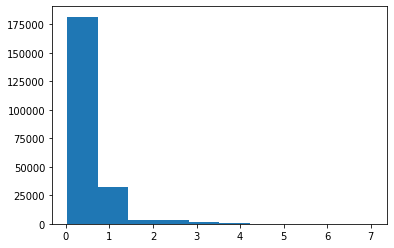

In [19]:
plt.figure()
plt.hist(heights, density = False, bins = 20)

In [22]:
breath_heights = []
breath_durations = []
for mouse in trials_raw.keys():
    breath_heights.extend(list(custom_breathlists[mouse]["Breath Height"]))
    breath_durations.extend(list(custom_breathlists[mouse]["Breath Duration (ms)"]))

In [64]:
tall_breaths_arrays = []
time_of_exp = []
for mouse in trials_raw.keys():
    tall_breaths = custom_breathlists[mouse][(custom_breathlists[mouse]["Breath Height"] > 0.032) & (custom_breathlists[mouse]["Breath Height"] < 0.731)]
    time_of_exp.extend(tall_breaths["index"])
    for index, row in tall_breaths.iterrows():
        padded = np.pad(row["Breath Data"], (0,2500-np.shape(row["Breath Data"])[0]), "constant")
        tall_breaths_arrays.append(padded)

In [60]:
print(len(time_of_exp))
print(len(tall_breaths_arrays))

2286
2286


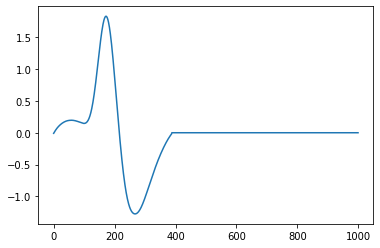

In [40]:
plt.figure()

plt.plot(tall_breaths_arrays[1010][:1000])

In [67]:
pre_cno = sum(all_pre_cno_arrays) / len(all_pre_cno_arrays)
post_cno = sum(all_post_cno_arrays) / len(all_post_cno_arrays)

In [ ]:
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("pre_post_cno_breaths.pdf")

for mouse in trials_raw.keys():

    pre_cno_analysis = custom_breathlists[mouse][(custom_breathlists[mouse]["Phase Number"] == 1)]
    post_cno_analysis = custom_breathlists[mouse][(custom_breathlists[mouse]["Phase Number"] == 2)]
    #breath_durations = np.append(breath_durations, np.array(custom_breathlists[mouse]["Breath Duration (ms)"]))
    #breath_heights = np.append(breath_durations, np.array(custom_breathlists[mouse]["Breath Height"]))
    all_post_cno_arrays = []
    all_pre_cno_arrays = []

    for index, row in pre_cno_analysis.iterrows():
        padded = np.pad(row["Breath Data"], (0,2500-np.shape(row["Breath Data"])[0]), "constant")
        all_pre_cno_arrays.append(padded)
    for index, row in post_cno_analysis.iterrows():
        padded = np.pad(row["Breath Data"], (0,2500-np.shape(row["Breath Data"])[0]), "constant")
        all_post_cno_arrays.append(padded)

    pre_cno = sum(all_pre_cno_arrays) / len(all_pre_cno_arrays)
    post_cno = sum(all_post_cno_arrays) / len(all_post_cno_arrays)

    line = static_data[static_data["MUID"] == mouse]["Line"].unique()[0]
    genotype = static_data[static_data["MUID"] == mouse]["Genotype"].unique()[0]

    plt.figure(figsize=(10,10))
    plt.title("Averaged Sum of Breaths for {}, {}, {}" .format(mouse,static_data[static_data["MUID"] == mouse]["Line"].unique()[0],
                                                                static_data[static_data["MUID"] == mouse]["Genotype"].unique()[0]), fontsize=20)
    plt.plot(pre_cno[:600], label = "Pre CNO")
    plt.plot(post_cno[:600], label = "Post CNO")
    plt.legend(fontsize= 20)
    
    pdf.savefig()

pdf.close()


In [23]:
print(len(all_pre_cno_arrays))

1920


In [31]:
print(len(all_pre_cno_arrays))
all_pre_cno_arrays.extend(all_post_cno_arrays)
print(type(all_pre_cno_arrays))
print(len(all_pre_cno_arrays))
pre_post_cno_analysis = np.vstack(all_pre_cno_arrays)

1920
<class 'list'>
3725


In [67]:

pca_data = np.vstack(tall_breaths_arrays)

pca = PCA(n_components=3)
projection_3d = pca.fit(pca_data)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
projection_3d = pca.fit_transform(tall_breaths_arrays)

[0.42206734 0.29347606 0.0941074 ]
0.8096507943392106


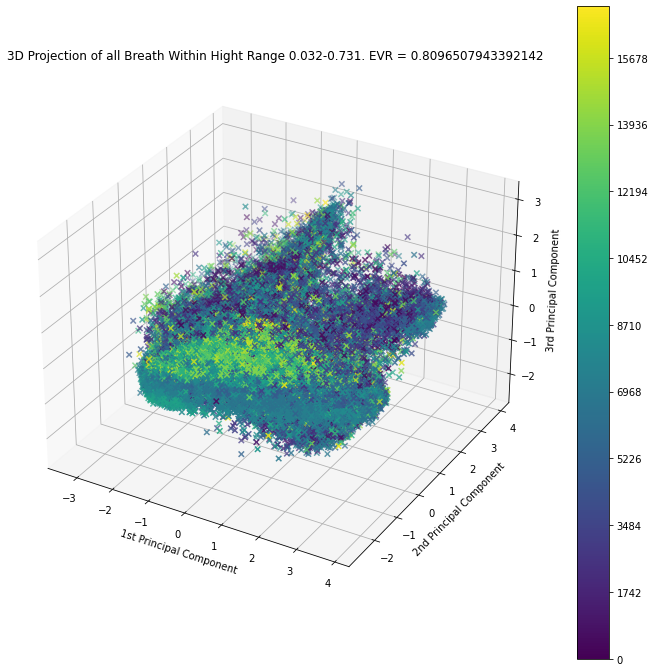

In [68]:
cmap = mpl.cm.viridis
bounds_list = np.arange(0,max(time_of_exp), math.ceil(max(time_of_exp)/256))
bounds = bounds_list

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

post_cno = ax.scatter3D(projection_3d[:,0], projection_3d[:,1],projection_3d[:,2], c =time_of_exp, marker = "x", s=30)

plt.title("3D Projection of all Breath Within Hight Range 0.032-0.731. EVR = {}" .format(np.sum(pca.explained_variance_ratio_)))
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
ax.set_zlabel("3rd Principal Component")
fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), orientation="vertical");


Text(0, 0.5, 'Second Principal Component')

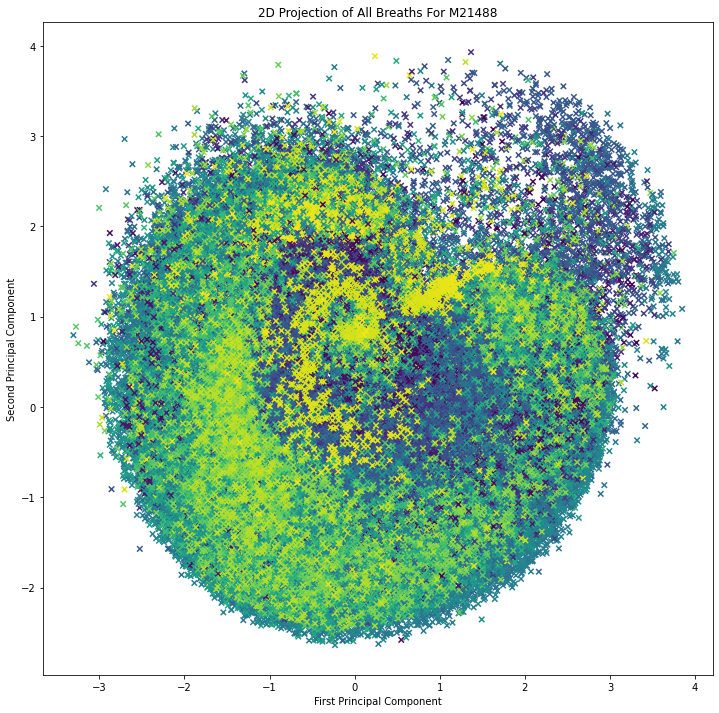

In [71]:
cmap = mpl.cm.viridis
bounds_list = np.arange(0,max(time_of_exp), math.ceil(max(time_of_exp)/256))
bounds = bounds_list

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)



plt.figure(figsize= (12,12))
plt.scatter(projection_3d[:,0],projection_3d[:,1], marker = "x", c = time_of_exp,s=30)
fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), orientation="vertical");

plt.title("2D Projection of All Breaths For M21488")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")


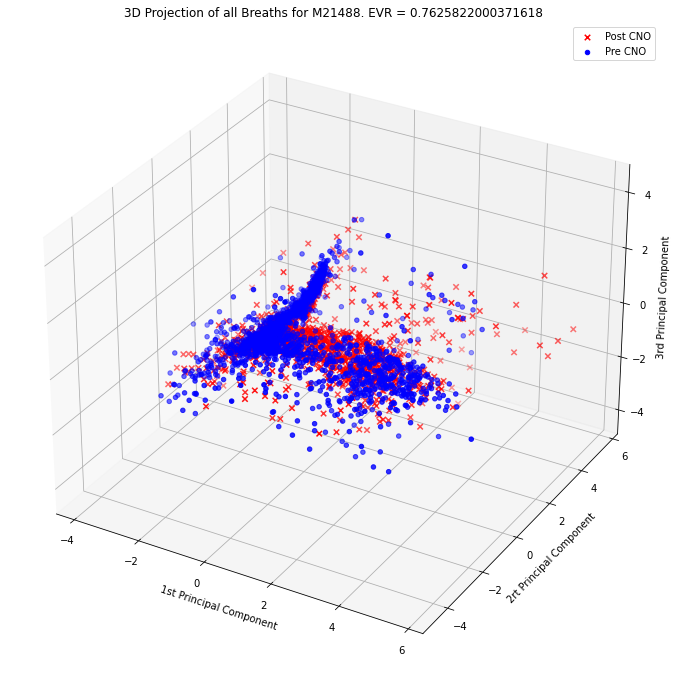

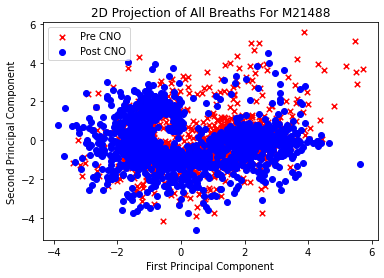

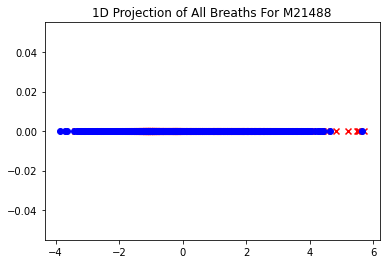

In [41]:
import matplotlib as mpl

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

post_cno = ax.scatter3D(projection_3d[1920:,0], projection_3d[1920:,1],projection_3d[1920:,2], marker = "x", color= "red",s=30)
pre_cno = ax.scatter3D(projection_3d[:1920,0], projection_3d[:1920,1],projection_3d[:1920,2], marker = "o", color="blue")

plt.title("3D Projection of all Breaths for M21488. EVR = {}" .format(np.sum(pca.explained_variance_ratio_)))
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2rt Principal Component")
ax.set_zlabel("3rd Principal Component")
plt.legend((post_cno,pre_cno),("Post CNO","Pre CNO"), fontsize = 10)

plt.figure()
plt.scatter(projection_3d[1920:,0],projection_3d[1920:,1], marker = "x", color= "red",s=30, label = "Pre CNO")
plt.scatter(projection_3d[:1920,0],projection_3d[:1920,1], marker = "o", color= "blue", label = "Post CNO")
plt.legend()
plt.title("2D Projection of All Breaths For M21488")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

plt.title("2D Projection of all Breath Within Hight Range 0.032-0.731")

(241648,)


Text(0.5, 1.0, 'Number of Breaths in Each Height Range')

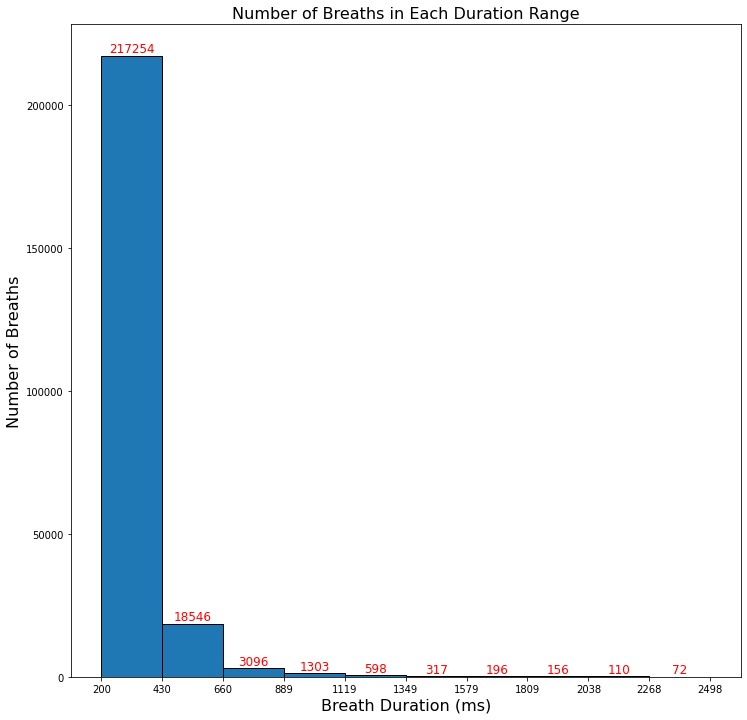

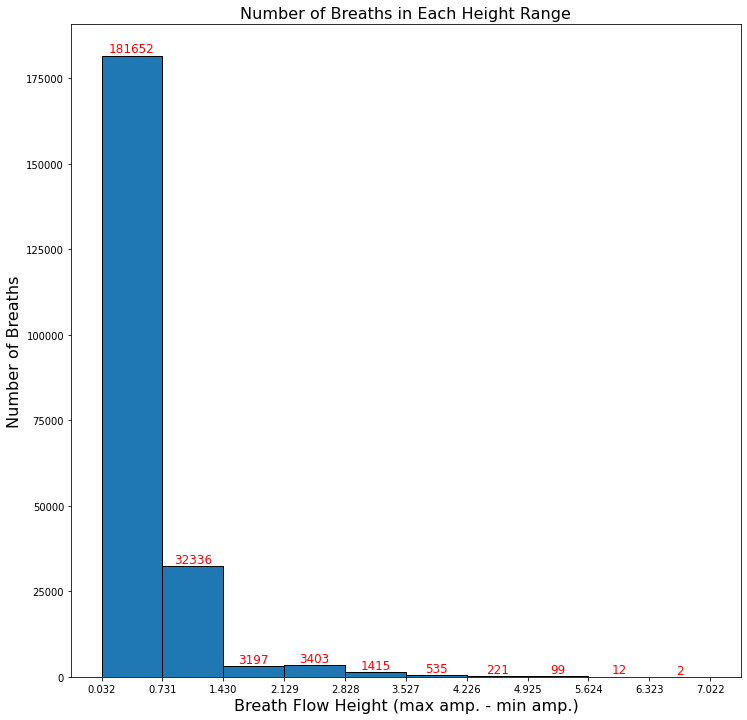

In [23]:
print(np.shape(breath_durations))

fig, ax = plt.subplots(figsize = (12,12))
counts, edges, bars = plt.hist(breath_durations,bins=10, edgecolor="black")

plt.bar_label(bars,c="Red", size = 12)
ax.set_xticks(edges)
plt.xlabel("Breath Duration (ms)", size = 16)
plt.ylabel("Number of Breaths", size = 16)
plt.title("Number of Breaths in Each Duration Range", size = 16)

fig, ax = plt.subplots(figsize = (12,12))
counts, edges, bars = plt.hist(breath_heights,bins=10,edgecolor="black")

plt.bar_label(bars,c="Red", size=12)
ax.set_xticks(edges)
plt.xlabel("Breath Flow Height (max amp. - min amp.)", size = 16)
plt.ylabel("Number of Breaths", size = 16)
plt.title("Number of Breaths in Each Height Range", size = 16)